# EATING POSTURE RECOGNITION OF FISH USING ACCELEROMETER SENSOR DATA WITH XGBOOST

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import fftpack
import math
from sklearn.datasets import make_classification
import joblib
import pickle5 as pickle

warnings.filterwarnings('ignore')


In [2]:
sys.path.append('../src/')

In [3]:
from utils import FeaturePreprocessing, TimeSeriesClassifier

## Data Loading

In [4]:
def read_data(path):
    files = [file for file in os.listdir(path) if file.endswith('.xlsx')]
    dfs = []
    for file in files:
        file_path = os.path.join(path, file)
        pond_name = os.path.splitext(file)[0]
        df = pd.read_excel(file_path)
        df['pond_code'] = pond_name
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data['date'] = (data['timestamp']/1000).apply(datetime.fromtimestamp)
    data.sort_values(by=['pond_code', 'date'], inplace=True)
    return data

In [5]:
df = read_data('../data')
df.head()

,timestamp,x,y,z,label,pond_code,date
8216,1657093314320,3,239,34,1,051,2022-07-06 14:41:54.320
8217,1657093314360,9,247,30,1,051,2022-07-06 14:41:54.360
8218,1657093314400,8,252,31,1,051,2022-07-06 14:41:54.400
8219,1657093314440,0,255,37,1,051,2022-07-06 14:41:54.440
8220,1657093314480,-12,252,39,1,051,2022-07-06 14:41:54.480


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 8216 to 19967
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  28392 non-null  int64         
 1   x          28392 non-null  int64         
 2   y          28392 non-null  int64         
 3   z          28392 non-null  int64         
 4   label      28392 non-null  int64         
 5   pond_code  28392 non-null  object        
 6   date       28392 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.7+ MB


## EDA

<Axes: title={'center': 'Number of data points by pond'}>

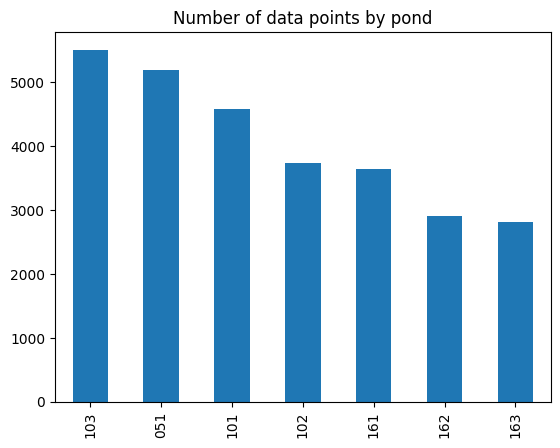

In [7]:
# count number endate by pond

df['pond_code'].value_counts().plot(kind='bar', title='Number of data points by pond')

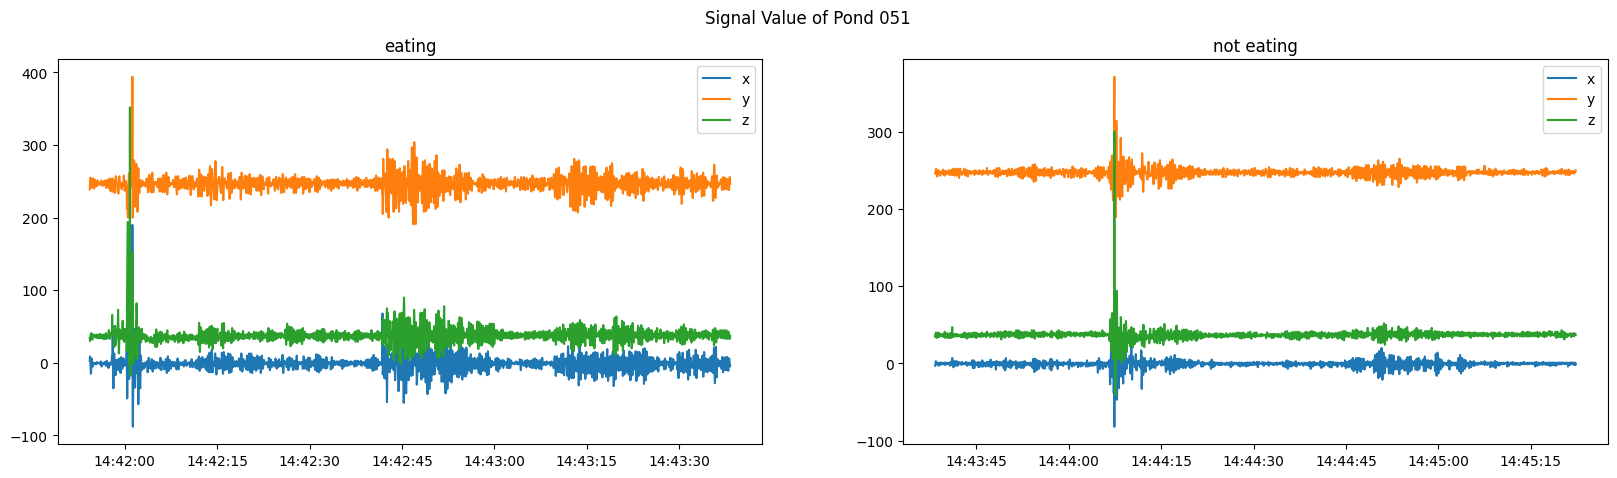

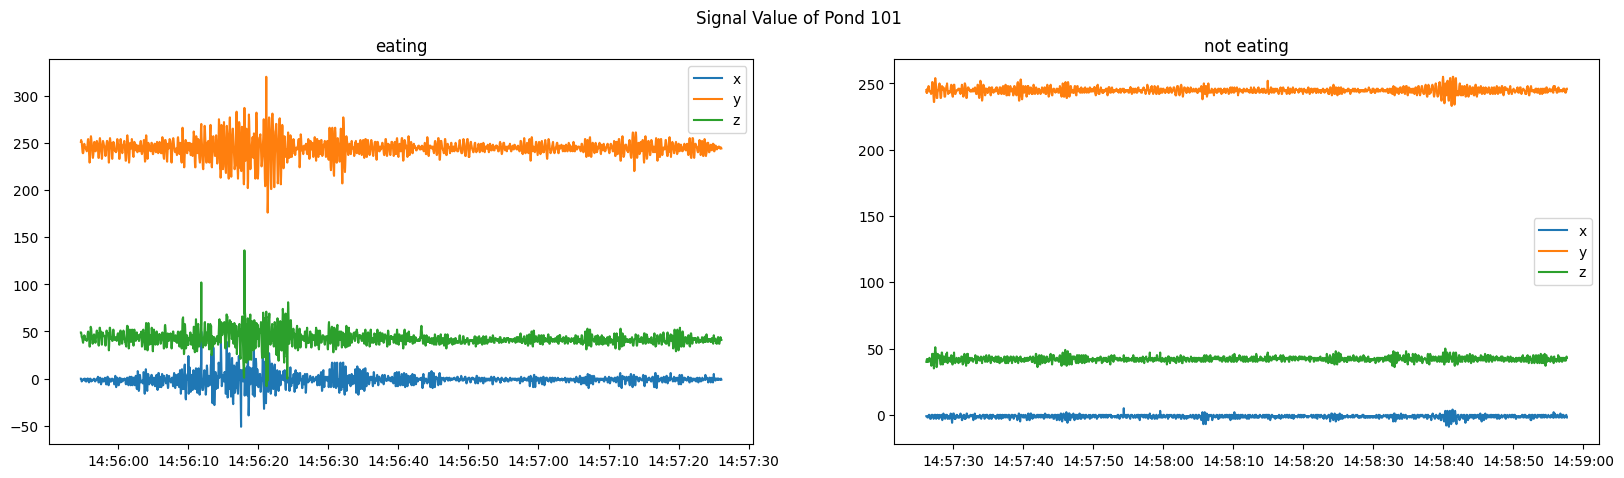

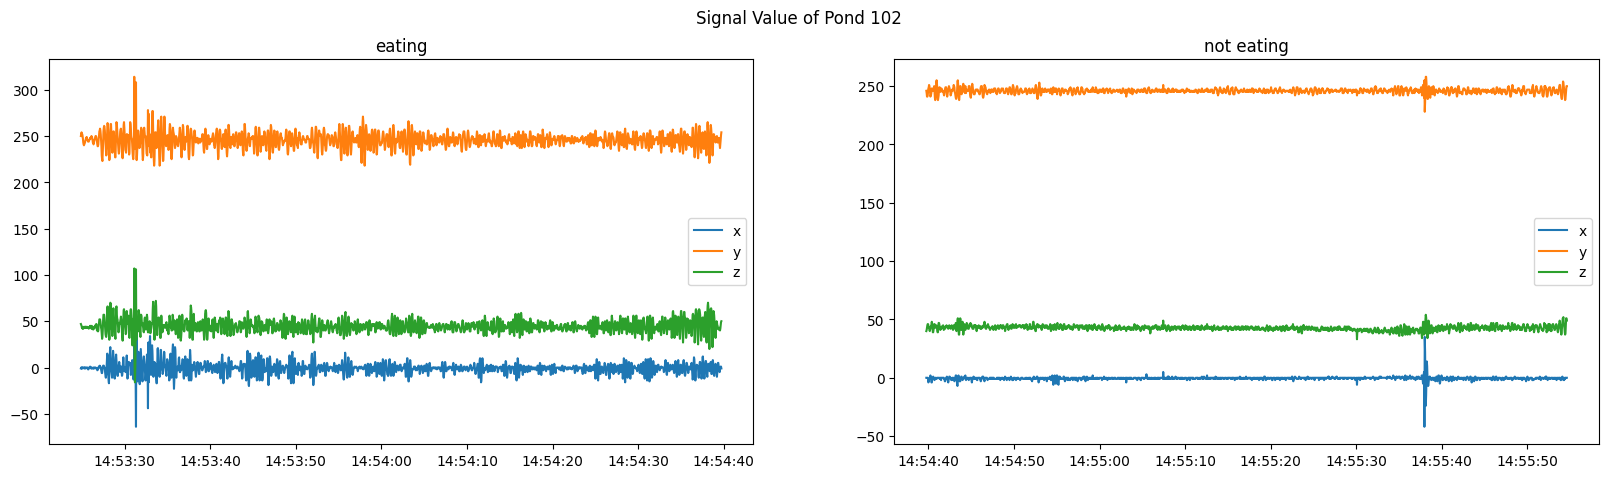

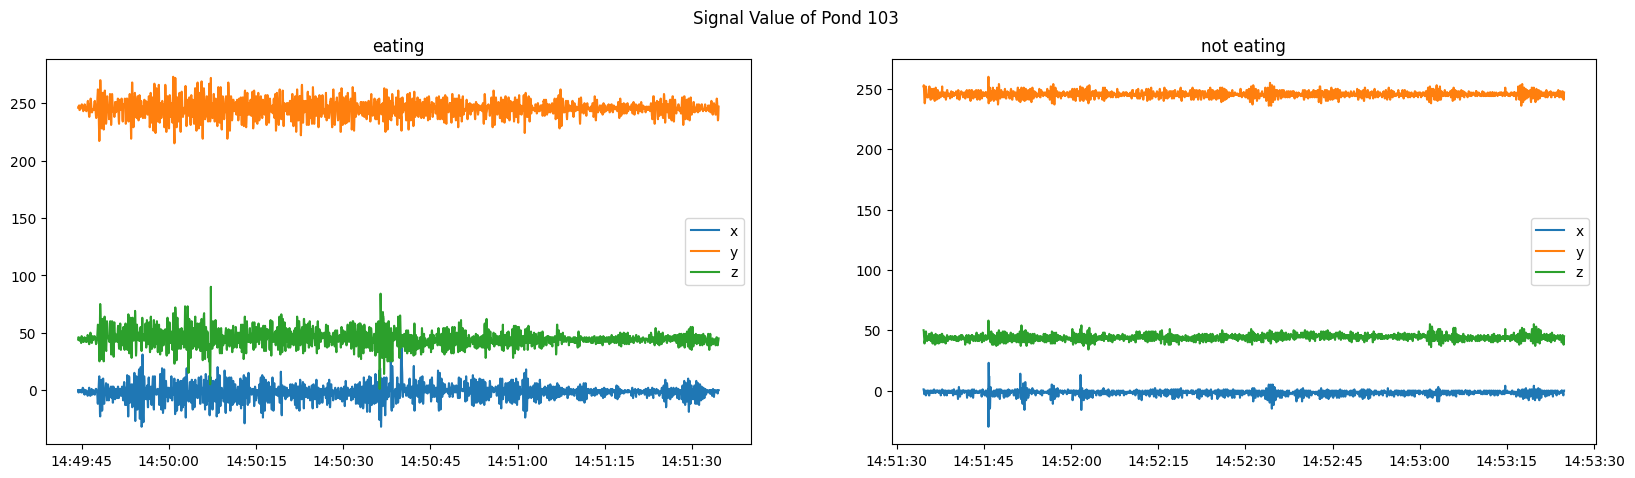

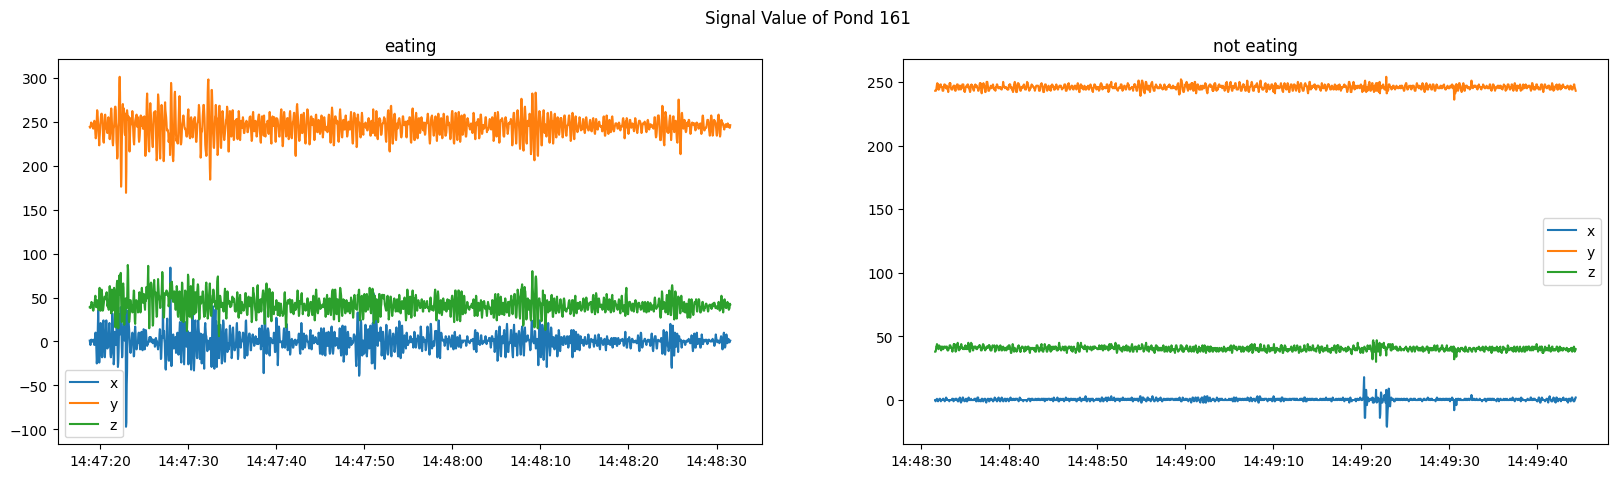

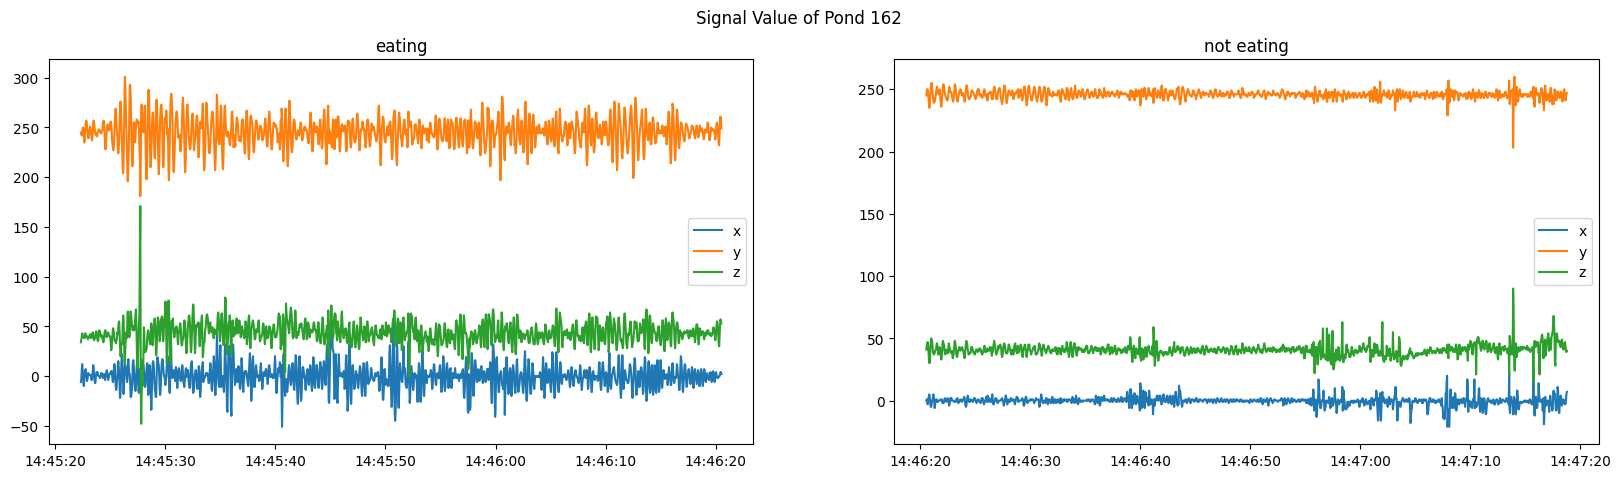

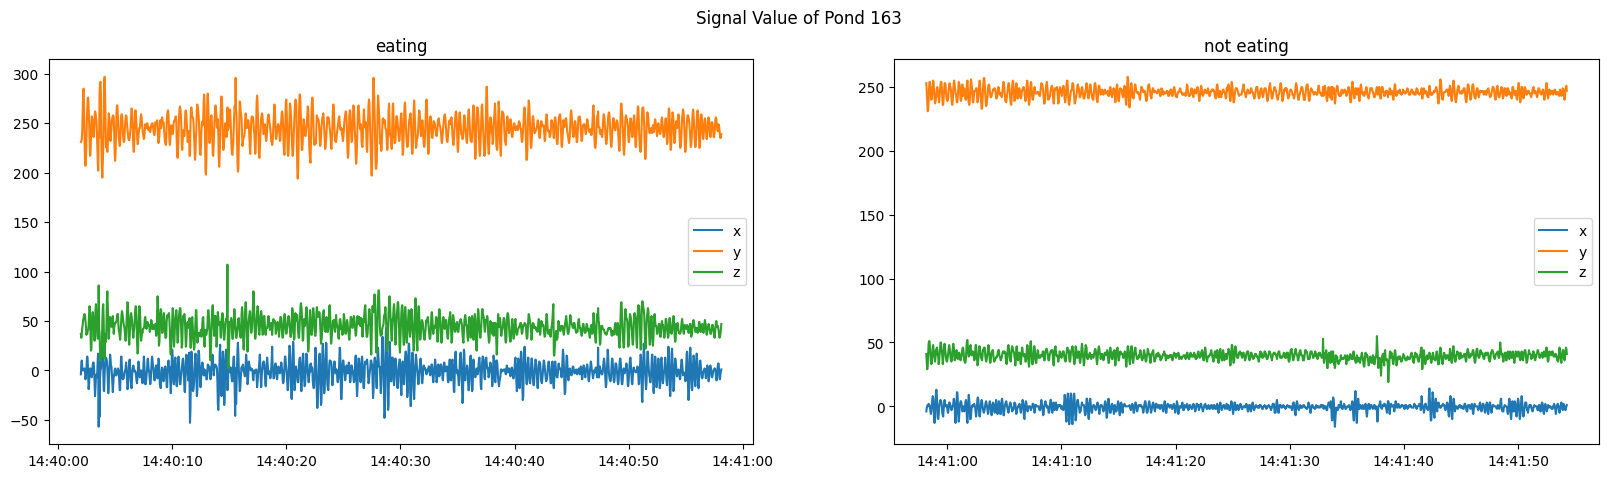

In [8]:
# signal by pond

ponds = df['pond_code'].unique()
for pond in ponds:
    pond_df = df[df['pond_code'] == pond]
    labels = pond_df['label'].unique()
    fig = plt.figure(figsize=(20, 5))
    for i, label in enumerate(labels):
        label_df = pond_df[pond_df['label'] == label]
        x = label_df['x']
        y = label_df['y']
        z = label_df['z']
        time = label_df['date']
        ax = fig.add_subplot(1, len(labels), i+1)
        ax.plot(time, x, label='x')
        ax.plot(time, y, label='y')
        ax.plot(time, z, label='z')
        if label == 0:
            ax.set_title("not eating")
        elif label == 1:
            ax.set_title("eating")
        ax.legend()
    fig.suptitle(f'Signal Value of Pond {pond}')
    # add suptitle
    plt.show()


In [9]:
print(df.date.min(), df.date.max())

2022-07-06 14:40:02 2022-07-06 14:58:57.640000


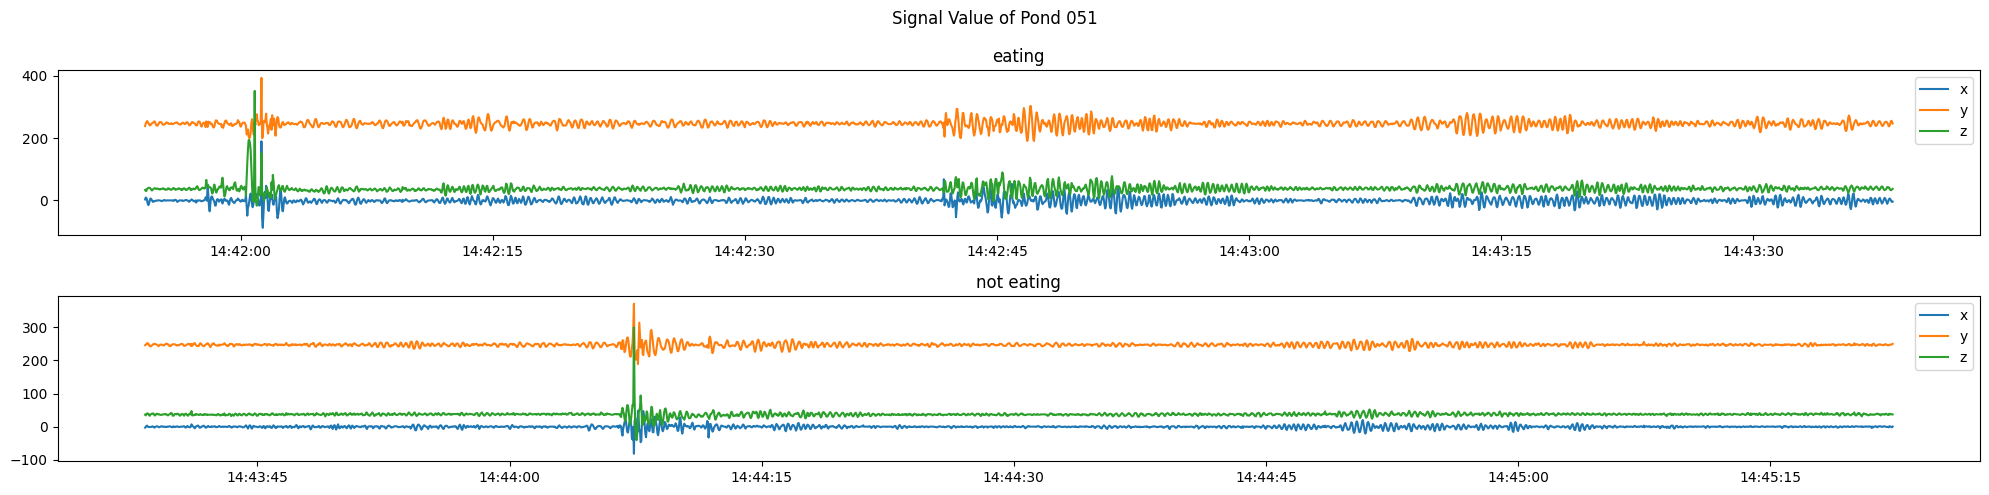

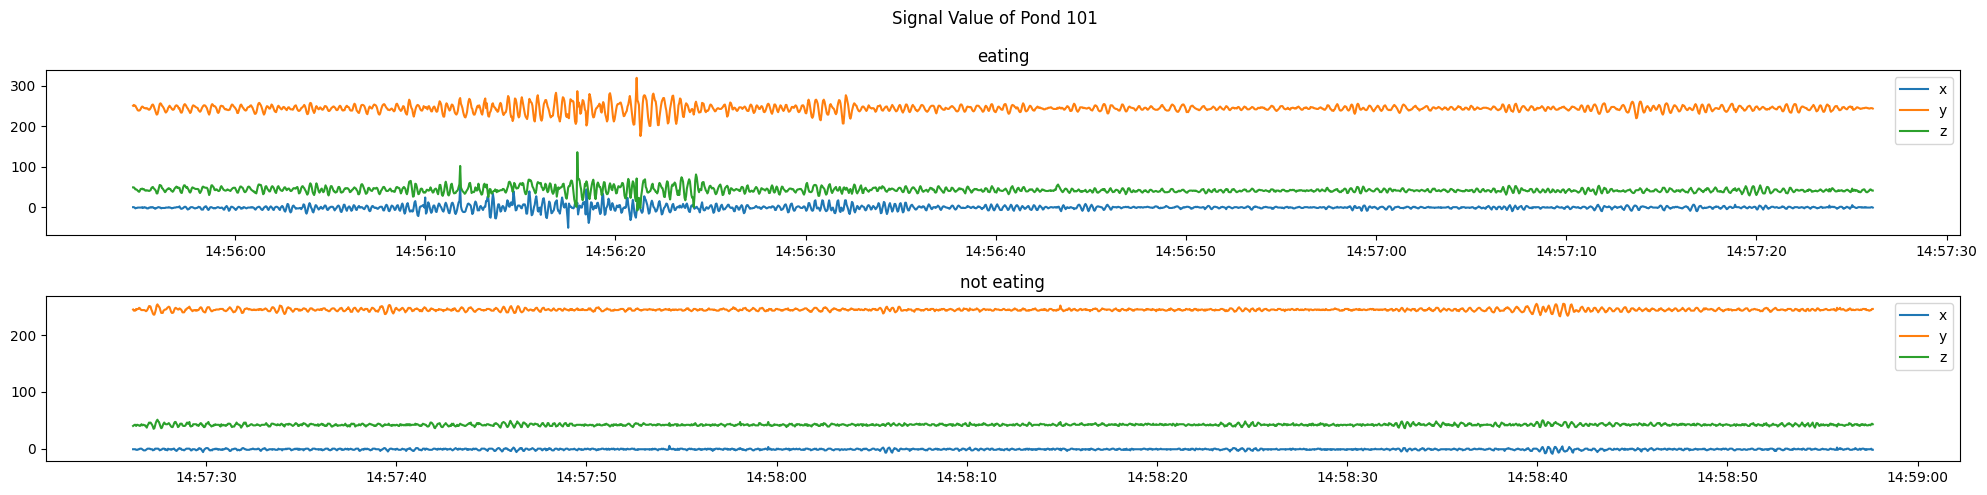

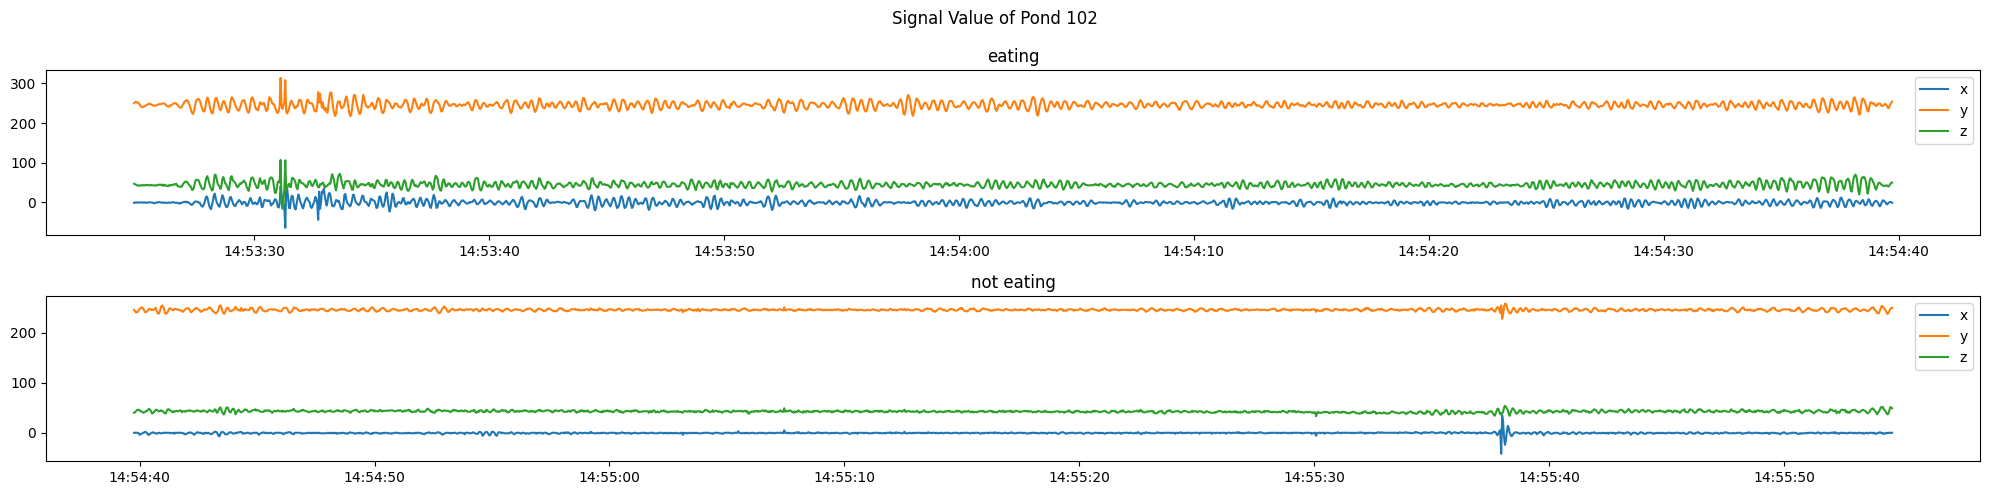

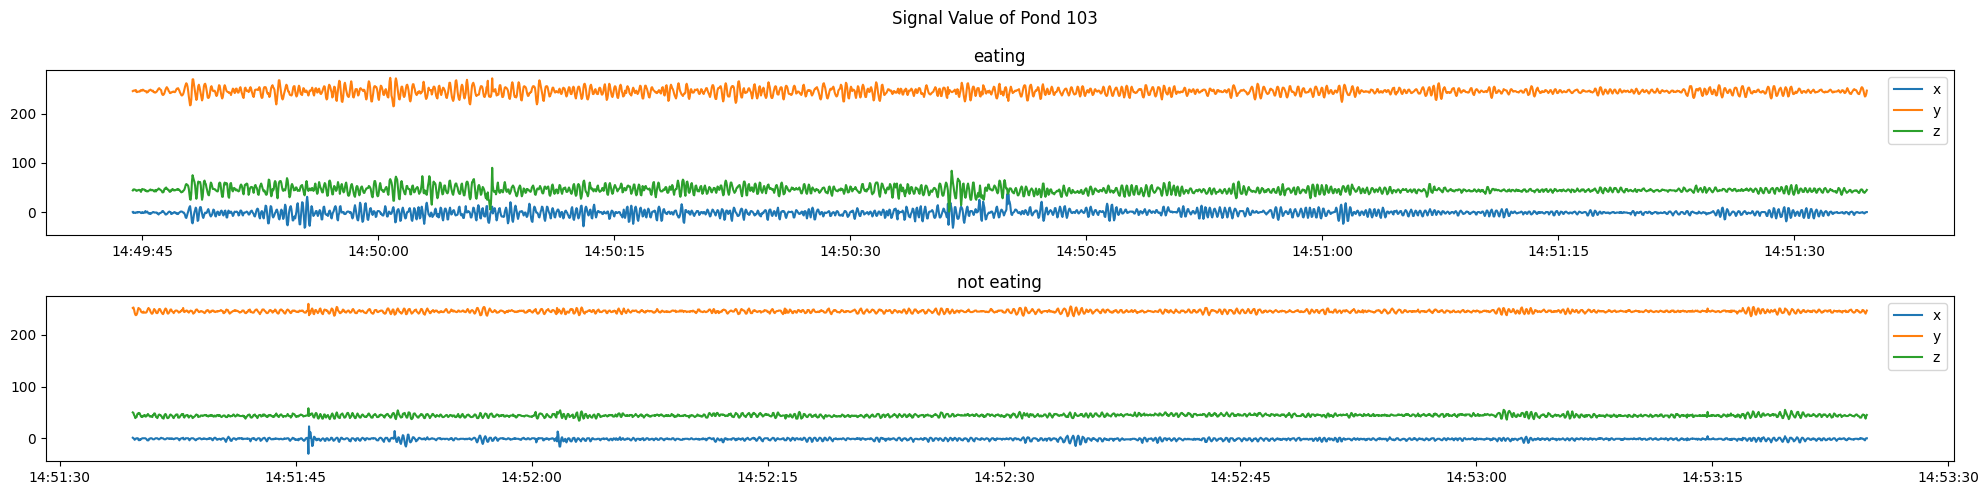

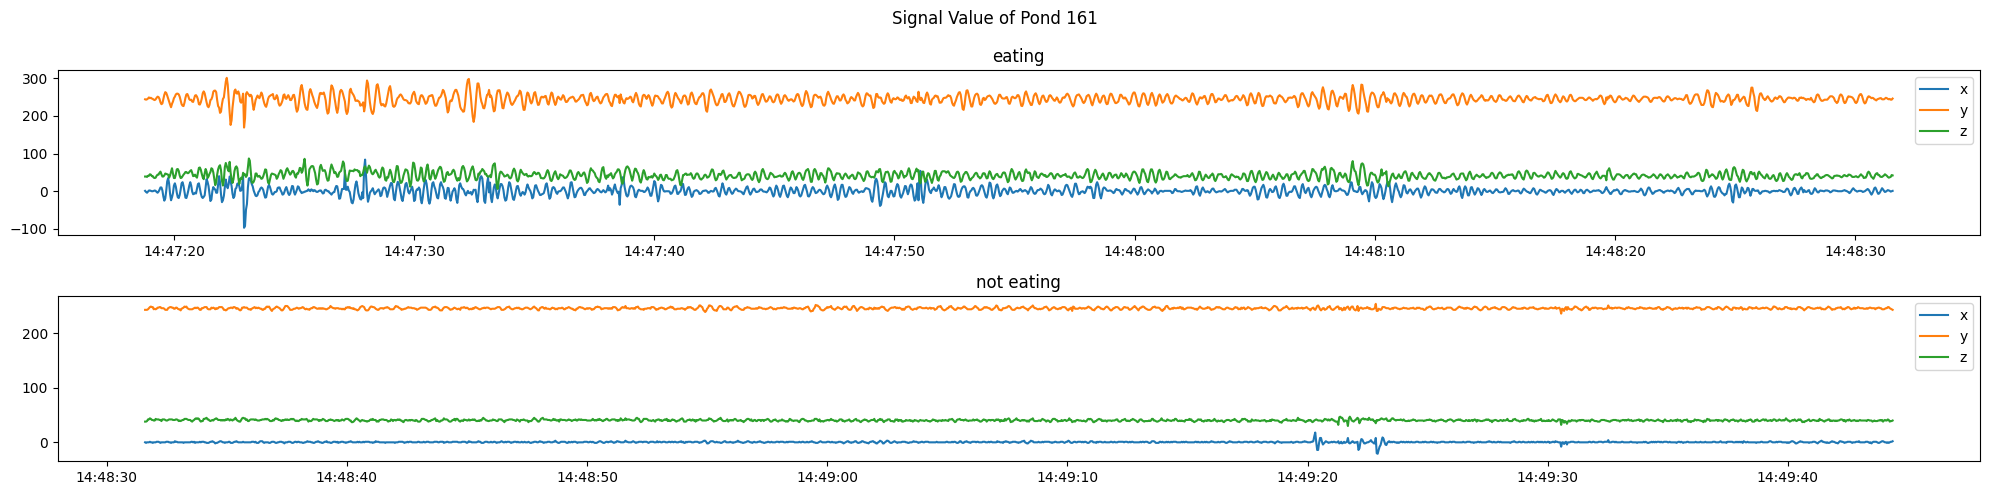

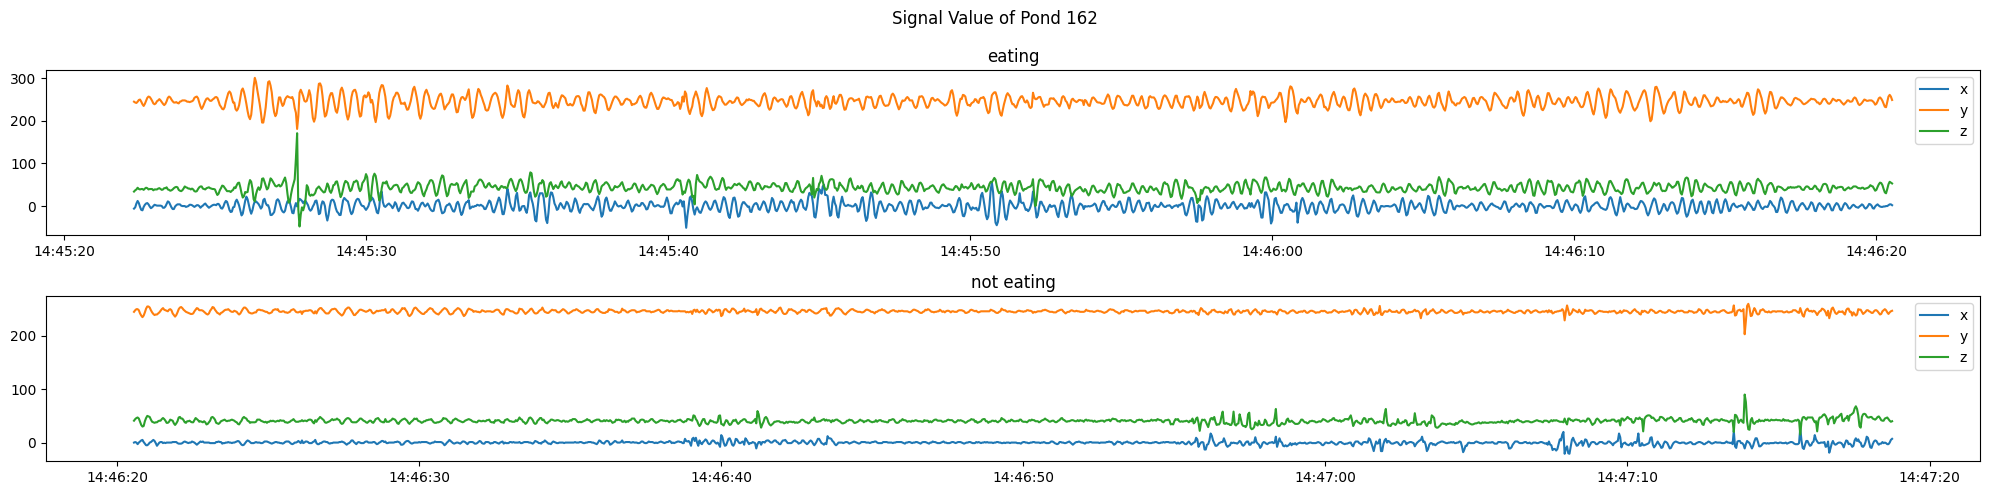

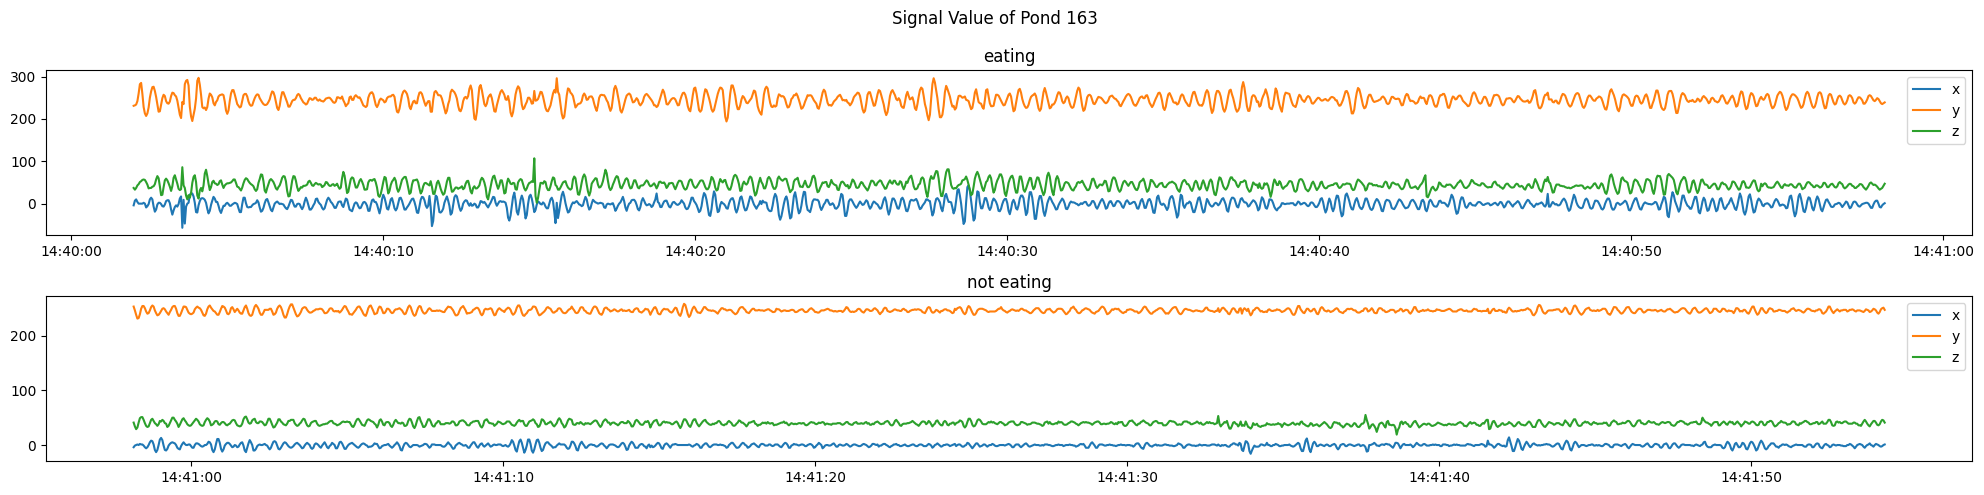

In [10]:
ponds = df['pond_code'].unique()
for pond in ponds:
    pond_df = df[df['pond_code'] == pond]
    labels = pond_df['label'].unique()
    fig = plt.figure(figsize=(20, 5))
    for i, label in enumerate(labels):
        label_df = pond_df[pond_df['label'] == label]
        x = label_df['x']
        y = label_df['y']
        z = label_df['z']
        time = label_df['date']
        ax = fig.add_subplot(len(labels), 1, i+1)
        ax.plot(time, x, label='x')
        ax.plot(time, y, label='y')
        ax.plot(time, z, label='z')
        if label == 0:
            ax.set_title("not eating")
        elif label == 1:
            ax.set_title("eating")
        ax.legend()
    fig.suptitle(f'Signal Value of Pond {pond}')
    plt.tight_layout()
    # add suptitle
    plt.show()

Text(0.5, 1.0, 'Duration of Eating and Not Eating by Pond')

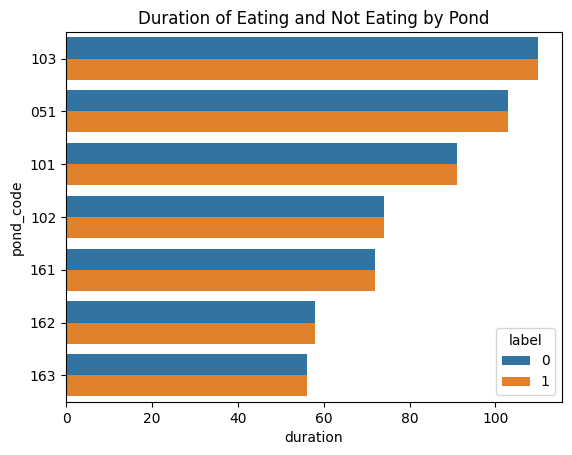

In [11]:
# eating duration by pond

groups = df.groupby(['pond_code', 'label']).agg({'date': lambda x: x.max() - x.min(), 
                                                'timestamp': lambda x: len(x)}).reset_index().rename(columns={'date': 'duration', 'timestamp': 'count'})
groups['duration'] = groups['duration'].apply(lambda x: x.seconds)

# bar plot of duration

sns.barplot(x='duration', y='pond_code', hue='label', data=groups.sort_values(by='duration', ascending=False))
plt.title('Duration of Eating and Not Eating by Pond')

                    

In [12]:
# correlation matrix

corr = df[['x', 'y', 'z', 'label', 'pond_code']].corr()
corr

,x,y,z,label
x,1.000000,0.001602,0.039605,-0.005180
y,0.001602,1.000000,0.186730,-0.026689
z,0.039605,0.186730,1.000000,0.110991
label,-0.005180,-0.026689,0.110991,1.000000


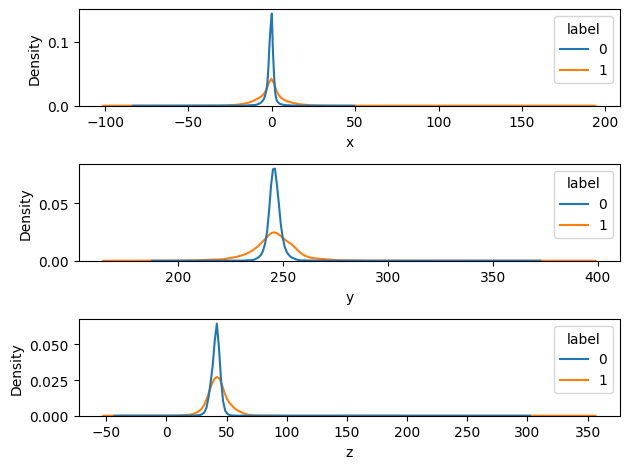

In [13]:
# kde plot of x, y, and z

fig, axes = plt.subplots(3, 1)
sns.kdeplot(data=df, x='x', hue='label', ax=axes[0])
sns.kdeplot(data=df, x='y', hue='label', ax=axes[1])
sns.kdeplot(data=df, x='z', hue='label', ax=axes[2])
plt.tight_layout()

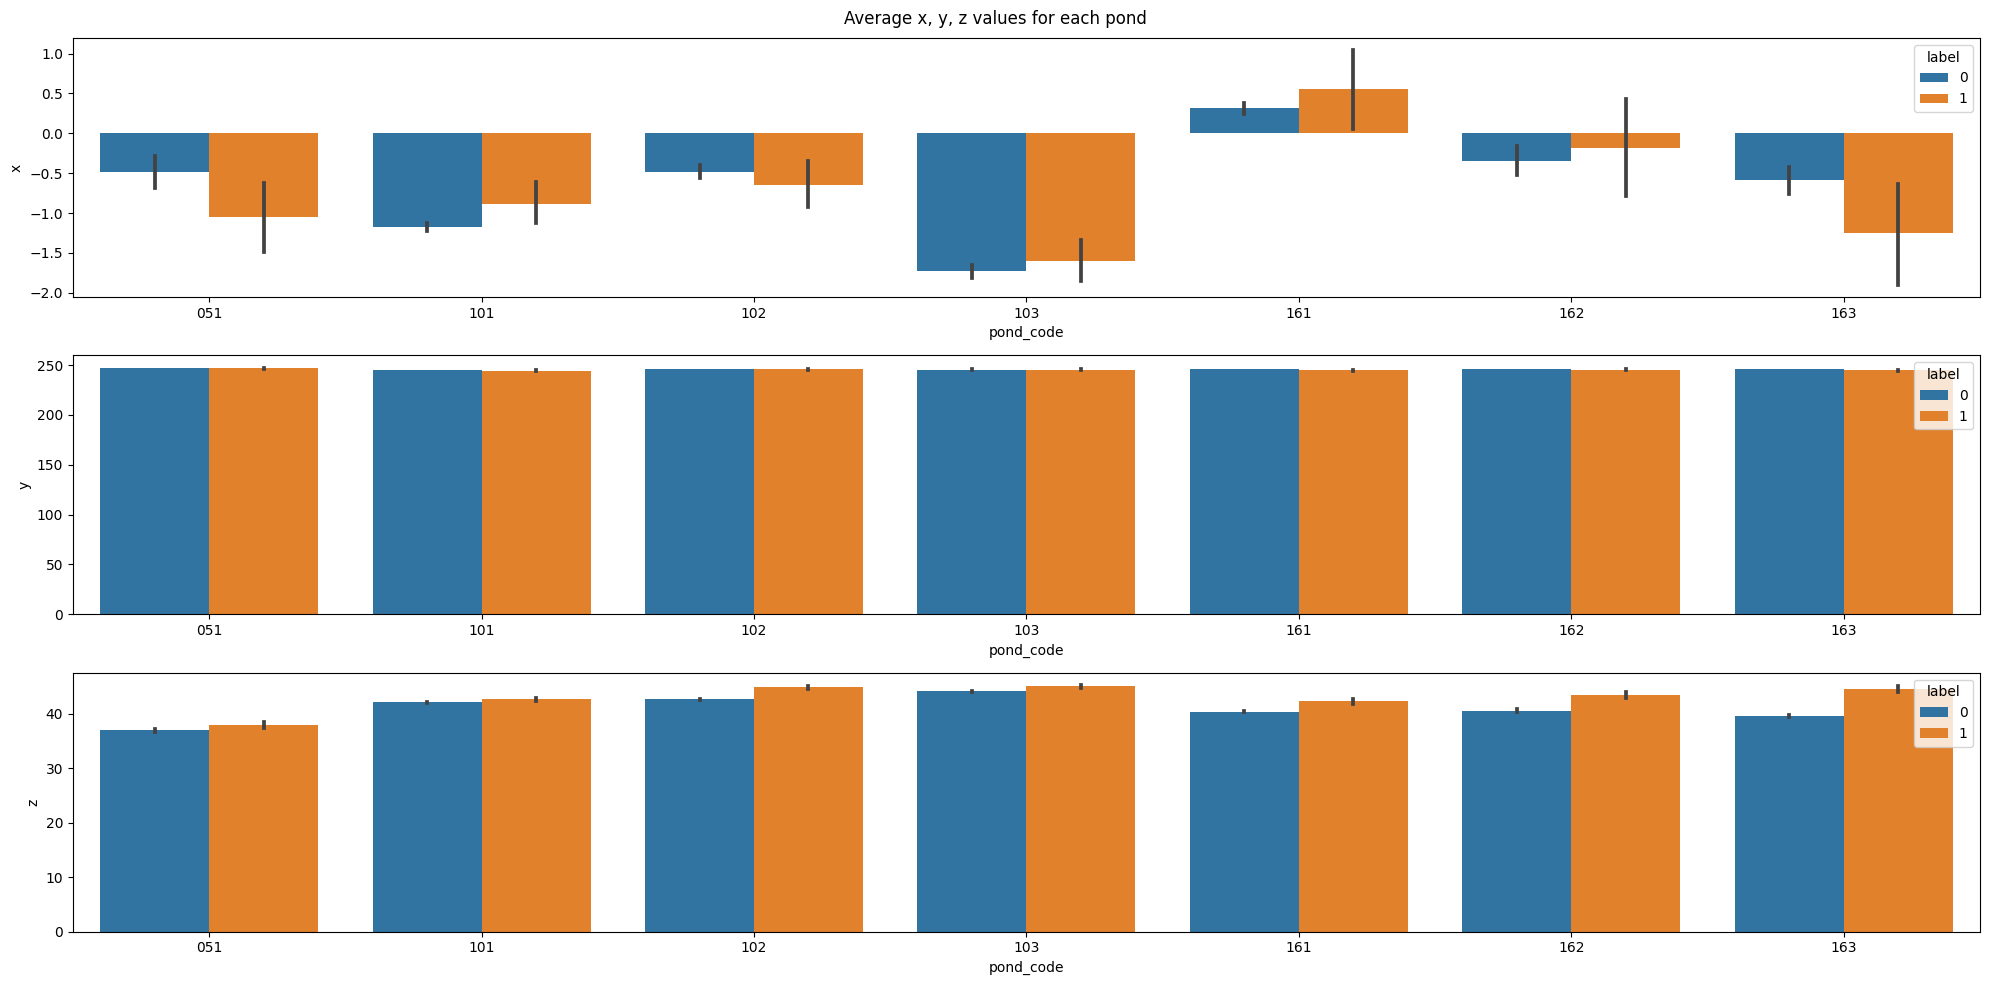

In [14]:
# find at average x, y,z values for each pond by label

df.groupby(['label','pond_code']).mean().reset_index()

# plot of average x, y, z values for each pond 

fig, axes = plt.subplots(3, 1, figsize=(20, 10))
sns.barplot(x='pond_code', y='x', hue='label', data=df, ax=axes[0])
sns.barplot(x='pond_code', y='y', hue='label', data=df, ax=axes[1])
sns.barplot(x='pond_code', y='z', hue='label', data=df, ax=axes[2])
plt.suptitle('Average x, y, z values for each pond')
plt.tight_layout()

## MODEL

In [15]:
preprocessor = FeaturePreprocessing(lag_size=20)
X_train, X_test, y_train, y_test = preprocessor.preprocess_by_id(df)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19774, 80) (8478, 80) (19774,) (8478,)


In [17]:
X_train.head()

,x_rolling_mean,x_rolling_std,x_rolling_min,x_rolling_max,y_rolling_mean,y_rolling_std,y_rolling_min,y_rolling_max,z_rolling_mean,z_rolling_std,...,y_lag_20,z_lag_20,pond_code_051,magn,pond_code_101,pond_code_102,pond_code_103,pond_code_161,pond_code_162,pond_code_163
8924,0.6,3.130495,-4.0,4.0,242.4,2.607681,239.0,245.0,39.0,2.345208,...,238.0,40.0,1.0,247.786198,0.0,0.0,0.0,0.0,0.0,0.0
11992,-0.6,0.547723,-1.0,0.0,248.4,1.140175,247.0,250.0,36.2,0.836660,...,250.0,36.0,1.0,250.601277,0.0,0.0,0.0,0.0,0.0,0.0
12671,5.6,4.505552,0.0,11.0,243.8,10.894953,231.0,256.0,40.6,4.505552,...,245.0,40.0,1.0,234.277613,0.0,0.0,0.0,0.0,0.0,0.0
11565,-5.6,17.357995,-32.0,12.0,233.6,18.174157,215.0,260.0,27.2,17.005881,...,212.0,0.0,1.0,215.302113,0.0,0.0,0.0,0.0,0.0,0.0
9812,-5.0,6.363961,-11.0,4.0,252.8,7.981228,240.0,260.0,38.2,11.388591,...,252.0,21.0,1.0,256.195238,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
model = TimeSeriesClassifier()
model.fit(X_train, y_train, model='rf')
model.evaluate(X_test, y_test)

Confusion Matrix:
[[3841  420]
 [ 352 3865]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4261
           1       0.90      0.92      0.91      4217

    accuracy                           0.91      8478
   macro avg       0.91      0.91      0.91      8478
weighted avg       0.91      0.91      0.91      8478

ROC AUC Score: 0.9089799632548646


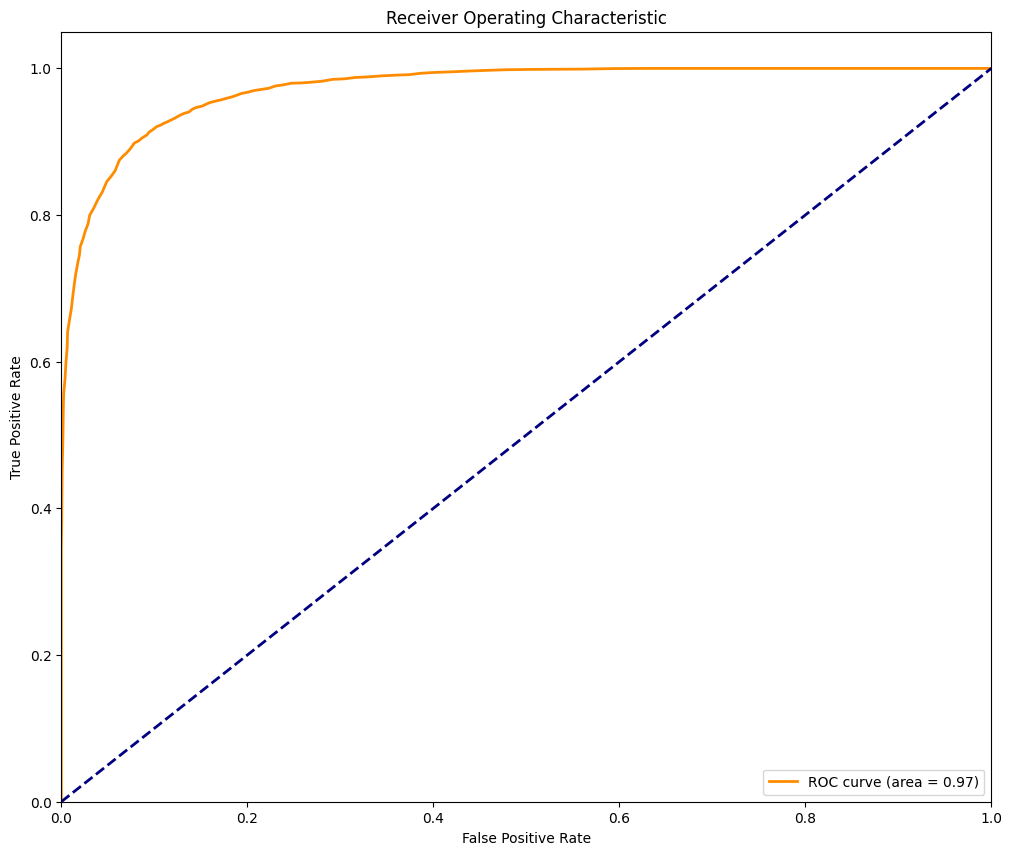

In [19]:
model.plot_roc_curve(X_test, y_test)

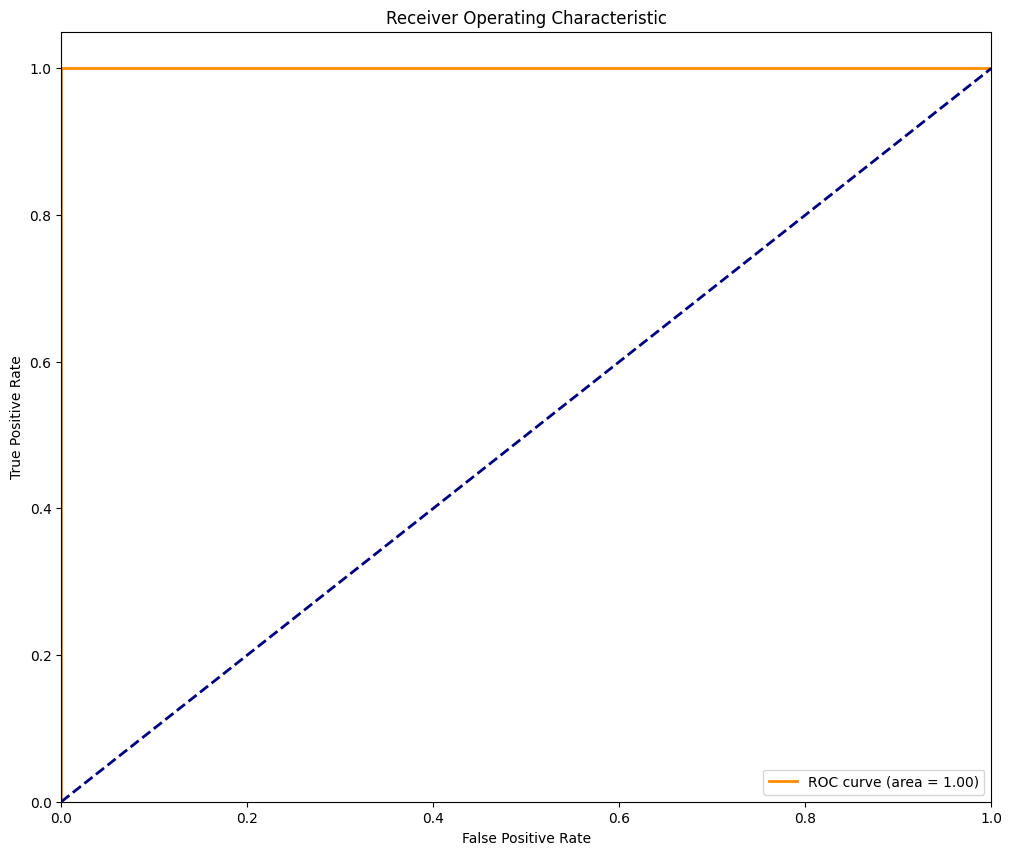

In [20]:
# overfitting detection

model.plot_roc_curve(X_train, y_train)

In [22]:
# Save model

#model.save_model('../xgb.pkl')